# Exploring trends in UK academia using PhD thesis metadata
#### Markus Hauru, January 2020

The British Library operates its [Electronic Theses Online Service](https://ethos.bl.uk) or EThOS, that keeps track of PhD theses accepted at UK higher education institutions. The Library also makes public a [data set](https://data.bl.uk/ethos/) of metadata for all theses in their catalogue. Quoting their website,

>The EThOS dataset lists virtually all UK doctoral theses ever awarded, some 500,000 dating back to 1787. All UK HE institutions are included, but we estimate records are missing for around 10,000 titles (2%).

The latest version of the dataset is from March 2018. The data includes the title, year, author, and institution for each thesis, as well as a link to a full record which may or may not include things like keywords or access to full texts.

In this notebook I explore this EThOS dataset to identify historical trends in UK academia. The notebook is structured roughly as follows:
* Prepare the data for analysis
* Study the number of PhDs produced as a function of institution and year
* Study trends in the popularities of individual words appearing in thesis titles
* Use a co-occurrence graph of words in thesis titles to detect academic fields, and score thesis titles on which field(s) they seem to belong to
* Use the above to study trends in the popularity of different academic fields

On the way we will for instance see a dramatic shift in the structure of UK academia in the 60s and 70s, look at some of the trendiest academic buzzwords of each decade since the 30s, and find out whether Cambridge really is more science-oriented than Oxford.

While I hope the findings here are of interest in themselves, this notebook is also an exercise for myself, to learn some basic exploratory data science tools and techniques, like basics of pandas, some network analysis, and new visualization techniques.

Many thanks go to Henri Seijo for some great feedback on this notebook.

## Setting up and preparing the data

First off, some imports of python libraries we'll be needing, and loading the data file into a pandas DataFrame. The script will automatically download the data file into the current working directory if it isn't there yet.

In [4]:
# Installing the `community` module.
# TODO I dislike installing packages without asking users
# first, but not sure what the best solution here is.
# !pip3 install python-louvain
import os
import operator as opr
import scipy as sp
import numpy as np
import pandas as pd
import networkx as nx
import community  # Network community finding
from matplotlib import pyplot as plt
import matplotlib.colors
import seaborn as sns
from IPython.display import set_matplotlib_formats

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [5]:
# For pretty and exportable matplotlib plots.
# If you are running this yourself and want interactivity,
# try `%matplotlib widget` instead.
set_matplotlib_formats('svg')
%matplotlib inline
# Set a consistent plotting style across the notebook using Seaborn.
sns.set_style("darkgrid")
sns.set_context("notebook")

/var/folders/wk/zmsrlr9s2cgdpdnqj5d522sw0000gr/T/ipykernel_41528/205340543.py:4: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [6]:
datafile = "EThOSCSV_201803.csv"
if not os.path.isfile(datafile):
    # Download and/or unzip the data file from the EThOS website.
    # We need a couple more imports for this.
    import zipfile

    datazip = "EThOSCSV_201803.zip"
    if not os.path.isfile(datazip):
        import requests

        dataurl = "https://data.bl.uk/ethos/EThOSCSV201803.zip"
        with requests.Session() as s:
            headers = {
                "User-agent": "Mozilla/5.0 (X11; Linux i686; rv:64.0) Gecko/20100101 Firefox/64.0"
            }
            r = s.get(dataurl, headers=headers)
            with open(datazip, "wb") as f:
                f.write(r.content)
    with zipfile.ZipFile(datazip, "r") as z:
        z.extractall(".")

In [7]:
df = pd.read_csv(datafile, encoding="ISO-8859-2")

To get an idea of what the rows in the DataFrame look like, here are some samples:

In [8]:
df.head()

,Title,Author,Institution,Date,Qualification,EThOS URL
0,Computation and measurement of turbulent flow ...,"Loizou, Panos A.",University of Manchester,1989.0,Thesis (Ph.D.),http://ethos.bl.uk/OrderDetails.do?uin=uk.bl.e...
1,Prolactin and growth hormone secretion in norm...,"Prescott, R. W. G.",University of Newcastle upon Tyne,1983.0,Thesis (Ph.D.),http://ethos.bl.uk/OrderDetails.do?uin=uk.bl.e...
2,Influence of strain fields on flame propagation,"Mendes-Lopes, J. M. C.",University of Cambridge,1983.0,Thesis (Ph.D.),http://ethos.bl.uk/OrderDetails.do?uin=uk.bl.e...
3,"Connectivity, flow and transport in network mo...","Robinson, Peter Clive",University of Oxford,1984.0,Thesis (Ph.D.),http://ethos.bl.uk/OrderDetails.do?uin=uk.bl.e...
4,The theory and implementation of a high qualit...,"Lower, K. N.",University of Bristol,1985.0,Thesis (Ph.D.),http://ethos.bl.uk/OrderDetails.do?uin=uk.bl.e...


The first observation to make is that the data is remarkably clean. There are a few NaNs that we need to drop:

In [9]:
print("Number of rows with NaNs: {}".format(df.isnull().any(axis=1).sum()))
df = df.dropna()

Number of rows with NaNs: 13


but with that done, there's little else to do. The Qualification column holds some oddities and misunderstandings, and there are few suspiciously short titles (my favourite being the 1977 thesis called "Beds"), but other than that, things seem in order. Most notably, the Institution and Date fields, which we'll be getting a lot of mileage from, seem spotless, without even a single typoed university name. The Dates are all just years, so I convert them to an integer type and rename the column.

In [10]:
df["Date"] = df["Date"].astype(np.int64)
df.rename(columns={"Date": "Year"}, inplace=True)

What is of some concern are the 10,000 or so theses that the British Library estimates are missing from the data set. Nowadays that's about a year's worth of theses, but it's also roughly the total number of theses in the data from before 1956. Now clearly some of the missing ones are from the last few years: Even though the data set is from 2018, the number of theses in it drops sharply after 2015. But there's probably a significant number missing from the early years as well, especially considering issues of record keeping. To illustrate the late and early parts of the data set:

In [11]:
thesiscounts_by_year = df.Year.value_counts().sort_index()

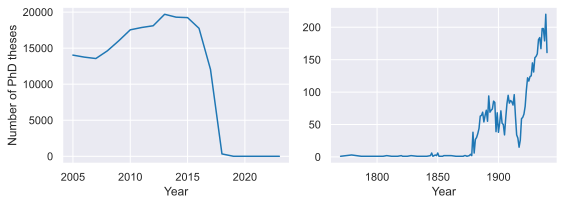

In [12]:
fig = plt.figure(figsize=(8, 3))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(thesiscounts_by_year.loc[2005:])
plt.ylabel("Number of PhD theses")
plt.xlabel("Year")

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(thesiscounts_by_year.loc[:1940])
plt.xlabel("Year")

plt.tight_layout();

Thus, to get a more reliable data set, I chop off parts from both ends. 2015 is clearly the natural late cutoff, since I doubt the PhD output has actually collapsed in the last few years. At the early end, before the end of WW1 the sample sizes for each year are clearly quite low, and based on this, as well as some odd features of the data pre-WW1, I've chosen to set the early cutoff at 1925.

In [13]:
late_cutoff = 2015
early_cutoff = 1925
thesiscounts_by_year = thesiscounts_by_year.loc[early_cutoff:late_cutoff]
df = df[(early_cutoff <= df.Year) & (df.Year <= late_cutoff)]

I also drop the columns we won't be using for anything. Makes for nicer reading when we print out slices of the DataFrame

In [14]:
df.drop(["Qualification", "EThOS URL"], axis=1, inplace=True)

## When and where: Number of theses per year and institution

With that basic setup out of the way, let's get into this.

First, a look at the number of PhD theses accepted in the UK over our chosen time period.

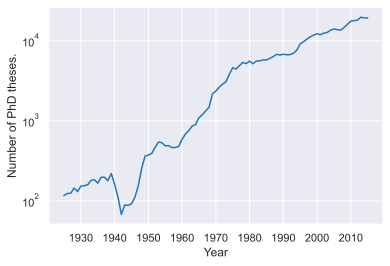

In [15]:
fig, ax = plt.subplots()
ax.semilogy(thesiscounts_by_year)
ax.set_ylabel("Number of PhD theses.")
ax.set_xlabel("Year")
ax.xaxis.set_major_locator(plt.MultipleLocator(10));

Note the logarithmic vertical axis. The two word summary here would clearly be "exponential growth". In 1925 a bit more than a hundred PhDs were awarded, and now we are approaching 20 000 per year. The most notable features on the way are
* a huge dip during WW2 in the middle of the otherwise steady exponential period from 1925 to 1960. (In the early-times plot a couple of cells above you can also see a dip during WW1, although the signal there is more noisy.) There's also a bump a few years after WW2, presumably from people who postponed the start of their studies until after the war and are then graduating in large batches.
* a period of even faster exponential growth in the 1960-1975 window. One explanation for this is baby boomers hitting typical PhD age (compare the above to a UK birth rate plot [here](https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/livebirths/bulletins/birthsummarytablesenglandandwales/2017) and shift by 25 or so years), but probably the most important driver of this growth is the huge structural change in academia that we'll see in a moment.
* a more moderate but steady pace from roughly 1975 onwards.

Note that when I talk about rate or pace of growth here I'm talking in multiplicative terms, meaning for instance that since 1975 the number of new PhDs has been growing by a roughly constant _percentage_ per year, not a constant number.

Next let's look at the contributions of different institutions to the total output of PhDs.

In [16]:
thesiscounts_by_yearandinst = (
    df.groupby(["Institution", "Year"])
    .size()
    .unstack("Institution")
    .fillna(0.0)
)
# Sort institutions based on PhD output in the last year of the time window.
thesiscounts_by_yearandinst = thesiscounts_by_yearandinst.sort_values(
    late_cutoff, axis="columns", ascending=False
)
# Compute the proportion of PhDs produced by each institution by year.
instratios_by_year = thesiscounts_by_yearandinst.divide(
    thesiscounts_by_year, axis="index"
)

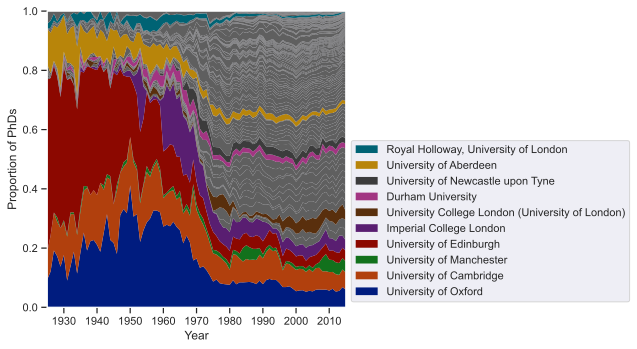

In [17]:
# We can't show the full legend with dozens of entries, so we restrict to a few
# of the most important ones.
num_legendentries = 10
num_entries = len(instratios_by_year.columns)

# Get the names and indices of the institutions that will cover the largest
# area in this plot. Sort them by index.
instratio_sums = instratios_by_year.sum().sort_values(ascending=False)
top_insts = instratio_sums.index[:num_legendentries]
top_inds = [list(instratios_by_year.columns).index(inst) for inst in top_insts]
top_inds, top_insts = zip(*sorted(zip(top_inds, top_insts)))

# Pick colors that highlight the entries in the legend.
legend_colors = sns.color_palette("dark", n_colors=num_legendentries)
# Color all the other entries with the same shade of gray, which we pick to be
# one of the highlight colors desaturated.
default_color = sns.set_hls_values(legend_colors[1], s=0.0)
all_colors = [default_color] * num_entries
# Put the highlight colors at the right positions in the list of all colors.
for i, c in zip(top_inds, legend_colors):
    all_colors[i] = c

# Make an exception to the general style by giving this plot ticks.
style_dict = {"xtick.bottom": True, "ytick.left": True}
with sns.axes_style(style_dict):
    plt.figure(figsize=(9, 5))
    lines = plt.stackplot(
        instratios_by_year.index,
        instratios_by_year.values.T,
        colors=all_colors,
        lw=0.05,
    )
    plt.ylabel("Proportion of PhDs")
    plt.xlabel("Year")
    plt.ylim(0.0, 1.0)
    plt.xlim(early_cutoff, late_cutoff)
    # Some fancy formatting of the legend. We show the most important legend
    # entries in the same order that they appear in in the figure and position
    # the legend out of the way.
    top_lines = [lines[i] for i in top_inds]
    plt.legend(
        reversed(top_lines),
        reversed(top_insts),
        loc="lower left",
        bbox_to_anchor=(1.0, 0.0),
    )
    plt.tight_layout()

This plot shows the proportion of PhDs coming from different universities, each grey or colored band being one institution. The institutions are ordered by the number of PhDs they produced in 2015, with the largest one being Oxford at the bottom. The colors and the legend highlight a few of the most historically prominent instutions (the ones that get the largest area in the above plot).

Here we can see the drastic change in the structure of higher education between roughly 1960 and 1980 that I mentioned above: There's an explosion in the proportion of PhDs coming from small universities. Until 1960 or so Oxford, Cambridge and Edinburgh produced 70-80% of PhDs in the country. By 1980 it was around 20%, and has stayed roughly constant since. They remain the largest PhD factories, but the field has been filled with dozens of smaller institutions.

A bit of Wikipedia browsing gives some context for this. During the shift period many new universities were founded (Sussex 1961, York 1963, Warwick 1965, ...), many others expanded greatly, and various colleges and other educational institutions were turned into universities. I'm not a historian, but for some background check Wikipedia on for instance the [University Grant Committee](https://en.wikipedia.org/wiki/University_Grants_Committee_(United_Kingdom)), [Robbins Report](https://en.wikipedia.org/wiki/Robbins_Report), and [Education Act of 1962](https://en.wikipedia.org/wiki/Education_Act_1962). I was previously aware that there was an expansion of higher education in many Western countries around this time, but the magnitude and speed of the shift in the above plot surprised me.

There are also some interesting individual stories in this same plot. Oxford used to dominate its rival Cambridge with a doctoral output several times larger until the late 60s, after which the two have been roughly equal. Even Oxford was for a time ecplised by Edinburgh though, which in some years produced more than 40% of all PhDs in the UK. The historical importance of Scotland was further bolstered by Aberdeen, which used to be one of the major players until the 60s, but is now just another mid-sized entry. (It should be said though that I suspect that the early years may suffer from a significant number of missing theses, that may skew the data to some degree. The main qualitative statement probably still stands though.) Imperial has a bulge of activity during the 1960s as it went through [a rapid expansion](https://en.wikipedia.org/wiki/Imperial_College_London#20th_century), a bit before many others followed suit.

Just to underline the fact that the fall in the relative importance of the top few institutions is not at all due to shrinking on their part but merely the growth of others, here are the absolute numbers of PhDs produced by the 4 institutions that contributed the most in 1960.

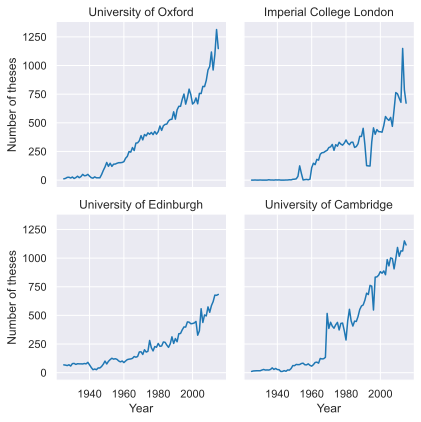

In [18]:
num_insts = 4
counts_top = thesiscounts_by_yearandinst.sort_values(
    1960, axis=1, ascending=False
)
counts_top = counts_top.iloc[:, :num_insts]
# Prepare to a format that sns.FacetGrid likes.
counts_top = (
    counts_top.unstack().reset_index().rename(columns={0: "Number of theses"})
)
g = sns.FacetGrid(
    counts_top, col="Institution", col_wrap=2, sharey=True, sharex=True
)
g.map(plt.plot, "Year", "Number of theses").set_titles("{col_name}");

## What are titles made of?

So far we've only looked at where and when PhD theses have been written. The dataset doesn't hold that much more information to toy with. It doesn't list departments or faculties, keywords or research fields, nor do I have easy access to full texts of the theses. But what it does have is the titles of these theses. Let's see what we can learn from them.

### Setting up the title analysis

Before we get to looking at trends in titles, we need to spend a moment setting up some machinery that we can then milk.

Thesis titles aren't exactly prose. They typically aren't full sentences and their grammatical forms vary wildly, which makes analysis of their linguistic structure tricky and, I would guess, in many cases a bit futile. Unlike with more structured text, almost as much information as in the title itself is contained in just a list of words appearing in the title. Lists of words are also easy to analyse, so we'll go with that.

To start, I strip the titles of any punctation and so called stop words like articles and prepositions that don't tell us much, and make everything lower case. I could also do what's called stemming, and collapse for instance "study", "studies", "studied" and "studying" all into a single word. I choose not to do this because as we'll see below, different inflections of the same stem word sometimes appear in significantly different kinds of titles. Moreover, with academic vocabulary, doing this properly isn't straight-forward: the stemming algorithm should for instance know to combine "phenomenon" and "phenomena", but perhaps not "phenomenal" or "phenomenology", and certainly not "phenolic". A quick experiment that I did with one stemmer also suggested that the results we'll be seeing wouldn't be greatly affected.

Another choice I make is to remove hyphens as unnecessary punctuation. Here you lose some and you win some. "Post-modern" should certainly be grouped together with "postmodern", but "biodiversity-ecosystem" (which appears in 5 titles) would be better split into two words.

In [19]:
def splitstr(s):
    """ For a string, remove most punctuation, lower case, and split into
    words. Return the unique words.
    """
    puncts = "!\"&'(),./:;<=>?[\\]`{|}-"
    words = s.lower().translate(str.maketrans("", "", puncts)).split()
    # Remove duplicates. We don't care if a word occurs multiple times in
    # the same title.
    words = tuple(set(words))
    return words


def filter_stopwords(words):
    """ Take a list of strings, filter out prepositions, articles, and other
    stop words.  We use a list of English stop words found here:
    https://www.textfixer.com/tutorials/common-english-words.txt
    """
    # Stop black (the code formatter) from automatically splitting this
    # across a gazillion lines with the fmt: off/on.
    # fmt: off
    stops = ["a", "able", "about", "across", "after", "all", "almost", "also", "am", "among", "an", "and", "any", "are", "as", "at", "be", "because", "been", "but", "by", "can", "cannot", "could", "dear", "did", "do", "does", "either", "else", "ever", "every", "for", "from", "get", "got", "had", "has", "have", "he", "her", "hers", "him", "his", "how", "however", "i", "if", "in", "into", "is", "it", "its", "just", "least", "let", "like", "likely", "may", "me", "might", "most", "must", "my", "neither", "no", "nor", "not", "of", "off", "often", "on", "only", "or", "other", "our", "own", "rather", "said", "say", "says", "she", "should", "since", "so", "some", "than", "that", "the", "their", "them", "then", "there", "these", "they", "this", "tis", "to", "too", "twas", "us", "wants", "was", "we", "were", "what", "when", "where", "which", "while", "who", "whom", "why", "will", "with", "would", "yet", "you", "your"]
    # fmt: on
    return tuple(word for word in words if word not in stops)

In [20]:
df["Words"] = df["Title"].apply(splitstr).apply(filter_stopwords)

To get the title analysis going, we want three different objects:
* A DataFrame that lists the total number of titles in which each word appears.
* The same thing but now per year. (We could do per institution as well, but let's leave that for later.)
* A so called co-occurrence graph (or network), i.e. a weighted graph where nodes are words and edges tell us which words appear together in titles and how often.

First, the easy bit, just counting word occurrences per year.

In [21]:
wordcounts_by_year = (
    df.groupby("Year")["Words"]
    .apply(lambda x: pd.Series(np.concatenate(x.tolist())).value_counts())
    .unstack("Year")
    .fillna(0.0)
    .T
)

In [22]:
total_wordcounts = wordcounts_by_year.sum(axis=0)
# Sort both total_wordcounts and wordcounts_by_year to have the most common
# words first.
order = (-total_wordcounts).argsort()
total_wordcounts = total_wordcounts[order]
allwords = total_wordcounts.index
wordcounts_by_year = wordcounts_by_year.reindex(allwords, axis=1)

Let's also compute the occurrences of each word per 1000 theses, in each given year, to measure their relative popularity.

In [23]:
wordratios_by_year = 1000 * wordcounts_by_year.divide(
    thesiscounts_by_year, axis=0
)

Making the co-occurrence graph requires some thought. First off, we've got around 190,000 distinct words in about 450,000 titles (academics like their jargon). However, only 20,000 or so of them appear in more than 10 thesis titles.

In [24]:
wordcount_cutoff = 10
print(
    "Number of unique words: {}. Number of theses: {}. Number of words with more than {} occurrences: {}.".format(
        len(total_wordcounts),
        len(df),
        wordcount_cutoff,
        (total_wordcounts > wordcount_cutoff).sum(),
    )
)

Number of unique words: 190252. Number of theses: 451755. Number of words with more than 10 occurrences: 21584.


Thus I choose to restrict the graph to this subset of words, since it makes it computationally much lighter to handle, without causing much of a loss: Words that only occur in a handful of thesis titles probably wouldn't add much to the analysis anyway.

In [25]:
mainwords = allwords[total_wordcounts > wordcount_cutoff]

Note also that when making word co-occurrence graphs of texts, co-occurrences are often given more weight if the words are next to each rather than just in the same sentence. I don't make this distinction since the titles are pretty short anyway, and word orders in titles can be unusual, making proximity less relevant. I also don't differentiate between the same word appearing in a title once or multiple times.

For the graph/network, I use the [NetworkX](https://networkx.github.io/) package. It represents graphs as adjacency lists, which suits our quite sparse co-occurrence graph well.

In [26]:
cooc_graph = nx.Graph()
cooc_graph.add_nodes_from(mainwords)
for words in df["Words"]:
    words = tuple(filter(lambda w: w in mainwords, words))
    # Loop over all pairs of two words `wi` and `wj` in `words`, but
    # so that `(wi, wi)` are not included, and if `(wi, wj)` is included
    # then `(wj, wi)` is not.
    for i in range(len(words)):
        wi = words[i]
        # The second loop starts from i+1 to avoid double-counting.
        for j in range(i + 1, len(words)):
            wj = words[j]
            if wi in cooc_graph[wj]:
                # This edge already exists, increment the weight
                cooc_graph[wi][wj]["weight"] += 1.0
            else:
                # This edge doesn't yet exist, create it.
                cooc_graph.add_edge(wi, wj, weight=1.0)

As we have it now, the edge weights of the graph just count the number of theses in which both words appear. This isn't quite what we want, since it's dominated by commonly occuring words. There are several different ways we could normalize the weights. To make a long story short, a choice that I've found works well for what I want to do with this graph later is normalizing the edge between A and B by average of the frequencies of A and B. This is symmetric (the graph remains undirected) and roughly speaking gives a large weight for edges that connect two words that appear approximately equally frequently and often together.

In [27]:
for w1, w2 in cooc_graph.edges:
    avg_count = (total_wordcounts[w1] + total_wordcounts[w2]) / 2.0
    cooc_graph[w1][w2]["weight"] /= avg_count

Finally, a few convenient functions for studying individual words: Getting example thesis titles with a given word in it, getting related words, and outputting a summary of a word (popularity plot, related words, examples).

In [28]:
def get_example_titles(word, n=1):
    """ For a given word `w`, return a tuple of `n` randomly picked thesis
    titles that have `w` in it.
    """
    titles_with_word = df[df["Words"].apply(lambda x: word in x)]["Title"]
    n = min(n, len(titles_with_word))
    examples = tuple(titles_with_word.sample(n).values)
    return examples


def get_related_words(w, n=5, weights=True):
    """ For a given word `w`, get the `n` words with heaviest edges connected
    to `w` in the co-occurrence graph.  Returns a list of tuples
    `(neighbour_word, weight)`, sorted by `weight`, or alternatively just a
    list of `neighbour_word`s if `weights=False`.
    """
    if w not in cooc_graph:
        # This word is not in the co-occurrence network.
        return ()
    node = cooc_graph[w]
    neighbourlist = ((k, v["weight"]) for k, v in node.items())
    neighbourlist = sorted(neighbourlist, key=opr.itemgetter(1), reverse=True)
    neighbourlist = neighbourlist[:n]
    if not weights:
        neighbourlist = [w[0] for w in neighbourlist]
    return neighbourlist


def output_word_summary(w, n_related=3, n_examples=3, plot=True):
    """ Print and plot (if `plot=True`) a summary of data for the word `w`.
    """
    print("Word: {}".format(w))
    if n_related > 0:
        print("Related words:")
        for neighbour in get_related_words(w, n=n_related):
            print(" {}: {}".format(*neighbour))
    if n_examples > 0:
        print("Example titles:")
        for title in get_example_titles(w, n=n_examples):
            print(" {}".format(title))
    if plot:
        fig, ax1 = plt.subplots(figsize=(5, 3))
        ax1.plot(wordcounts_by_year[w], color="black")
        title = "Number and proportion of theses\nwith '{}' in the title".format(
            w
        )
        ax1.set_title(title)
        ax1.set_ylabel("Absolute number (black)".format(w))
        ax1.set_xlabel("Year")
        ax2 = ax1.twinx()
        ax2.plot(wordratios_by_year[w], color="darkred")
        ax2.set_ylabel("Per 1000 theses (red)".format(w))
        fig.tight_layout()

### Buzzwords from the past

With all that set-up out of the way, let's see if these titles hold some interesting. First off, what are the most commonly occuring words in thesis titles, and how does their popularity vary over time?

--------------------------------------------------
Word: study
Related words:
 case: 0.2097815470376635
 comparative: 0.1153317337503033
 development: 0.05929317390646284
Example titles:
 A study of the macro to micro process of persuasion for advertising in context towards a meso dominant logic model of consumer behaviour
 A dialogic endeavour : a study of three newly qualified teachers' journeys towards dialogic teaching
 A finite element and analytical study on reverse channel connection to steel tubular column
--------------------------------------------------
Word: studies
Related words:
 structural: 0.09210299541553205
 synthesis: 0.050235956766631146
 synthetic: 0.048787855902122194
Example titles:
 Studies on the SlyA transcription regulators of Escherichia coli and Salmonella typhimurium
 Some spectroscopic studies with a dye laser
 Off-site art curating : case studies in Taiwan (1987-2007)
--------------------------------------------------
Word: development
Related words:
 sy

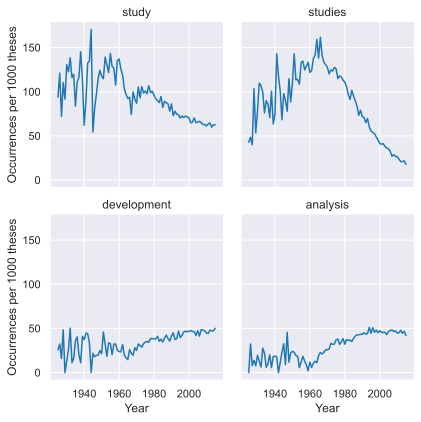

In [29]:
num_topwords = 4
topwords = allwords[:num_topwords]
topword_ratios = wordratios_by_year.loc[:, topwords]
# Prepare to a format that sns.FacetGrid likes.
topword_ratios = (
    topword_ratios.unstack()
    .reset_index()
    .rename(columns={0: "Occurrences per 1000 theses", "level_0": "Word"})
)
g = sns.FacetGrid(
    topword_ratios, col="Word", col_wrap=2, sharex=True, sharey=True,
)
g.map(plt.plot, "Year", "Occurrences per 1000 theses")
g.set_titles("{col_name}")
for w in topwords:
    print("-" * 50)
    output_word_summary(w, plot=False)

Nothing too exciting here: Generic terms that appear in all kinds of titles. Both "study" and "studies" have clearly fallen into relative disuse since the 70s.

Much more interesting than the most popular words are those whose popularity has been fleeting. One could get at this in a million different ways, but here's one that I found interesting. For each decade, find the top 3 words whose popularity that decade was the most disproportionately large compared to their popularity over all time. In other words, rank words by number of occurrences in a given decade, divided by total number of occurrences. To not have this be dominated by words occurring in only a handful of theses, I further restrict to words with at least 100 occurrences in total. I'll also print for each word some of the commonly co-occurring words, to give some context.

In [30]:
num_topwords = 3
occurrence_cutoff = 100
notrare_words = total_wordcounts > occurrence_cutoff
for start_year in range(1930, 2020, 10):
    end_year = start_year + 10
    print("{}s:".format(start_year))
    decade_top_words = (
        wordcounts_by_year.loc[start_year:end_year, notrare_words].sum()
        / total_wordcounts
    ).sort_values(ascending=False)
    for w in decade_top_words.index[:num_topwords]:
        neighbours = get_related_words(w, n=3, weights=False)
        print("{:15}  {}".format(w, neighbours))
    print("-" * 79)

1930s:
notes            ['introduction', 'glossary', 'edited']
solvents         ['eutectic', 'nonpolar', 'nonaqueous']
prognosis        ['diagnosis', 'aetiology', 'infarction']
-------------------------------------------------------------------------------
1940s:
substances       ['humic', 'pectic', 'psychoactive']
constitution     ['alloys', 'constitutional', 'discursive']
cases            ['hundred', 'review', 'report']
-------------------------------------------------------------------------------
1950s:
radioactive      ['disposal', 'tracer', 'waste']
substances       ['humic', 'pectic', 'psychoactive']
constituents     ['nitrogenous', 'milk', 'leaves']
-------------------------------------------------------------------------------
1960s:
elementary       ['particles', 'particle', 'physics']
polysaccharides  ['algal', 'pectic', 'enzymic']
bubble           ['chamber', 'columns', 'coalescence']
-------------------------------------------------------------------------------
1970s:
gev

The 30s, 40s, and 50s look quite similar, with pretty generic terminology, especially science terminology, trending high, but from that point on things get more specialised and interesting. Plenty of particle physics terminology is featured in the 60s and 70s (a bubble chamber is a type of particle physics experiment and GeV/c, gigaelectronvolts per speed of light, is a a unit for momentum in particle physics), when new particles were constantly being discovered. The 80s, 90s and 2000s have a lot of computer science and communication technology words in the lead (ATM in most cases stands for asynchronous transfer mode). They give way to "mindfulness" and "resilience" in the 2010s, nicely reflecting changing cultural themes and attitudes in the past decade. Many of the words are also directly related to breakthroughs that generated flurries of research activity in their wake, such as monoclonal antibodies and graphene, which both lead to a Nobel Prize within a few years of discovery.

Notable is also the relative lack of social sciences and humanities vocabulary. We'll come back to this later when studying popularities of academic fields.

The prospective rabbit holes here are endless, but just for highlighting, here's a bit more detail on a few select words from the above list.

--------------------------------------------------
Word: bubble
Related words:
 chamber: 0.23267326732673269
 columns: 0.0691358024691358
 coalescence: 0.060836501901140684
Example titles:
 It's time to kick a** and chew bubble gum : an ideological critique of narrative in action games
 Phytoplankton induced changes of air bubble residence time in seawater
 Bubble coalescence from multiple entry nozzles in fluidized beds
--------------------------------------------------
Word: diagenesis
Related words:
 sedimentology: 0.14255765199161424
 sandstones: 0.10810810810810811
 jurassic: 0.07514450867052024
Example titles:
 The sedimentology and diagenesis of copper-bearing rocks of the southern margin of the Damaran Orogenic Belt, Namibia and Botswana
 The sedimentology and diagenesis of the Kullsberg and Boda Limestones, Siljan District, Central Sweden
 Modelling vadose diagenesis of holocene carbonate sands
--------------------------------------------------
Word: globalisation
Related word

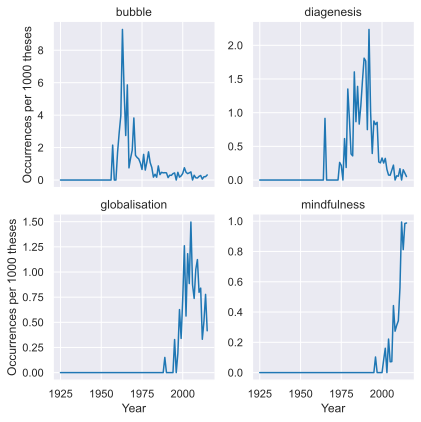

In [31]:
selectwords = ["bubble", "diagenesis", "globalisation", "mindfulness"]
selectword_ratios = wordratios_by_year.loc[:, selectwords]
# Prepare to a format that sns.FacetGrid likes.
selectword_ratios = (
    selectword_ratios.unstack()
    .reset_index()
    .rename(columns={0: "Occurrences per 1000 theses", "level_0": "Word"})
)
g = sns.FacetGrid(
    selectword_ratios, col="Word", col_wrap=2, sharex=True, sharey=False,
)
g.map(plt.plot, "Year", "Occurrences per 1000 theses")
g.set_titles("{col_name}")
for w in selectwords:
    print("-" * 50)
    output_word_summary(w, plot=False)

## Identifying fields of research from titles

Individual words like those above tell us stories of individual scientific discoveries and hot topics, but they have their limits if we want to study larger academic trends. However, one would naturally expect the co-occurrences of words in titles to follow patterns, where words typical to research fields and subfields would often appear together. Our next goal is to see if this indeed happens, and assuming it does (yes, it does), use it to
* identify what are the academic field distinctions that the co-occurrence graph holds.
* analyse how the popularities of these different fields have varied.

So we want to find groups of words that typically appear together. This could be called clustering, but in the context of networks/graphs like our co-occurrence graph, it usually goes by the name of community structure. There's plenty of research done on algorithms for identifying communities. I use below one quite well-known one, the [Louvain algorithm](https://arxiv.org/abs/0803.0476), which is a heuristic algorithm based on optimizing the modularity of the graph, i.e. minimizing the weight of edges connecting different communities and maximizing the weight of edges internal to communities. I tried a few other methods as well, most notably label-propagation and stochastic block models, but at least with the parameters that I tried they seemed to produce communities that were either very small or did not match well my human intuition of which words I would expect to be related.

If you are running this notebook yourself, you can safely go make a cup of tea at this point. The community finding takes around 5 minutes on my laptop.

In [32]:
partition = community.best_partition(cooc_graph)

In [33]:
# community.best_partition returns a dictionary of {word: community_label}.
# Lets turn that into a DataFrame and extract the lists of words belonging to each community.
community_labels = pd.DataFrame(
    {"Label": tuple(partition.values())},
    index=partition.keys(),
    dtype="category",
)
communities = tuple(
    map(tuple, community_labels.groupby("Label").groups.values())
)

Let's take a look at what we found.

In [34]:
print("Number of communities: {}".format(len(communities)))
print("Numbers of words in the communities:")
print([len(c) for c in communities])
print("Some example words from each community:")
num_example_words = 40
for c in communities:
    print(c[:num_example_words], end="\n\n")

Number of communities: 12
Numbers of words in the communities:
[3571, 5796, 3, 5085, 2912, 8, 4189, 2, 9, 4, 2, 3]
Some example words from each community:
('study', 'development', 'analysis', 'investigation', 'case', 'social', 'between', 'reference', 'use', 'behaviour', 'approach', 'theory', 'management', 'new', 'model', 'aspects', 'performance', 'education', 'factors', 'impact', 'evaluation', 'learning', 'english', 'health', 'policy', 'british', 'towards', 'special', 'influence', 'uk', 'change', 'practice', 'england', 'assessment', 'children', 'production', 'process', 'political', 'comparative', 'relationship')

('studies', 'using', 'systems', 'control', 'modelling', 'design', 'synthesis', 'system', 'properties', 'novel', 'structure', 'application', 'applications', 'high', 'models', 'based', 'methods', 'dynamics', 'structural', 'techniques', 'processes', 'flow', 'data', 'experimental', 'networks', 'metal', 'power', 'problems', 'reactions', 'energy', 'processing', 'structures', 'materi

So according to the Louvain algorithm, our co-occurrence graph has 19 communities, out of 5 are non-tiny. I'll just discard the 14 small ones as uninteresting (not every word needs to be in a community, recall that our graph only includes the ~20,000 most common words anyway), and focus on the 5 big ones.

Gladly, they make quite good sense to human intuition. The first one has a lot of social sciences vocabulary in it, we'll call it Social; the second one is clearly hard sciences, maths, and engineering or just Science for short; the second is medicine and biochemistry, aka Biomed; the fourth one clearly Humanities; and the fifth has a theme of ecology and geography, and we'll call it Eco/Geo.

At this point a note about stability of these communities is in order. I've been running the same community finding on graphs made with only subsets of the data set, leaving out some of the theses, and also tried including more or less words in the co-occurrence graph (remember we picked the arbitrary cutoff of only including words with at least 10 occurrences). The main communities fortunately appear quite stable under such perturbations. Including somewhat less words or less theses sometimes makes Humanities merge with Social sciences, but otherwise the communities stay roughly as they are. Going the other way, including more rare words in the graph may for instance sometimes cause particle physics to separate from the rest of Science. These kinds of granularity differences, of whether a field splits into a further subfields or merges with its academic neighbour, is quite natural, and doesn't in my view undermine the analysis in any significant way.

Next, what we would like to do is assign to each word and thesis title a score or label, that would tell us roughly which field(s) it belongs in. The naive way would be to just label each word with its respective community, and count e.g. how many Humanities words appear in a given title. This doesn't seem quite fair though. Clearly some words are in some sense more "deeply" in each community. For instance the word "theory" gets grouped into social sciences, but obviously it occurs in other contexts as well, unlike the word "policy", which is pretty dead giveaway. To account for this effect, I give each word a score for how strongly they are connected to each community. This score starts out being 1 for the community the word belongs in and 0 for the others. I then add to it the total weight of edges connecting this word to words in a given community. So a word that is in the Humanities community and co-occurs mostly with other Humanities words gets a high Humanities-score, whereas a word that co-occurs with words from several different communities will have significant scores for all of them. Finally, we'll normalize the scores by the total sum within a field, so for instance the Social score of each word will be divided by the sum of Social scores of all words. This accounts for the fact that some fields include more words, and these words may be more strongly connected in our co-occurrence graph. We'll also multiply the resulting scores by 10,000, just to produce more human-readable numbers.

First off, use some key words in each community to anchor the names of the fields.

In [35]:
field_keywords = {
    "education": "Social",
    "cell": "Biomed",
    "magnetism": "Science",
    "ecology": "Eco/Geo",
    "philosophy": "Humanities",
}

For the field scores, first give each word a score of 1.0 for the community it belongs in according to the Louvain classification. Drop all the small communities we don't care about, and name the columns of the DataFrame with the names given above.

In [36]:
wordscores = pd.get_dummies(community_labels).astype(np.float_)

In [37]:
# Rename the columns whose names are in field_keywords.
for word, field in field_keywords.items():
    current_label = wordscores.loc[word, :].idxmax()
    wordscores.rename(columns={current_label: field}, inplace=True)
# Drop all other columns.
for c in wordscores.columns:
    if not c in field_keywords.values():
        wordscores.drop(c, axis=1, inplace=True)
fieldnames = wordscores.columns

Then add to the scores the weights of the edges connecting each word to words in different communities. This is easy to do with a matrix product with the adjacency matrix of the graph.

To give an example, "tunnel" belongs to the Science community, so it starts out having a score of 1.0 for Science and 0.0 for the other fields. It has graph edges connecting it to many other Science words, that increase it Science score, but it also has an edge with weight 0.043 connecting it to "boring", which is an Eco/Geo word, and thus we add 0.043 to the Eco/Geo score of "tunnel".

In [38]:
# So to get the scores we want, we need to take the matrix product of the
# adjacency matrix of the co-occurrence graph with the current score matrix,
# wordscores.values. The graph is way too big to build the whole adjacency
# matrix as a dense matrix, but luckily NetworkX has us covered, with the
# possibility of creating a scipy sparse matrix instead. However, the pandas
# dot function for matrix products insists on converting everything to a dense
# matrix to do the product, so we'll have to manually work with the
# scipy.sparse matrix instead of a DataFrame. It's not too bad though.
adjacency_matrix = nx.to_scipy_sparse_matrix(
    cooc_graph, nodelist=wordscores.index, format="csr"
)
for c in fieldnames:
    column_vec = wordscores[c].to_numpy()
    scores = adjacency_matrix.dot(column_vec)
    scores_series = pd.Series(scores, index=wordscores.index)
    wordscores[c] += scores_series
del adjacency_matrix  # Release the memory

Finally, normalize the scores, and give all the words we did not include in our graph (the ones with fewer than 10 occurrences) a score of 0.0 for everything.

In [39]:
wordscores *= 10000 / wordscores.sum(axis=0)

In [40]:
wordscores = wordscores.reindex(allwords, fill_value=0.0)

To check that the scoring system makes sense, let's print out the top words for each field.

In [41]:
num_topwords = 6
for c in fieldnames:
    print("\nWords with highest scores for {}:".format(c))
    print(wordscores.sort_values(c, ascending=False)[:num_topwords])


Words with highest scores for Social:
               Social   Science  Humanities   Eco/Geo    Biomed
education    6.731376  0.338529    1.075394  0.278021  0.246520
case         6.720405  0.670708    1.115557  0.838112  0.362805
experiences  6.514327  0.301990    0.768338  0.187945  0.619091
school       6.511356  0.346066    0.837274  0.252485  0.322448
students     6.465365  0.373327    0.767093  0.161477  0.249918
health       6.291271  0.558116    0.540989  0.456644  1.104925

Words with highest scores for Science:
           Social   Science  Humanities   Eco/Geo    Biomed
using    2.144769  4.513893    0.255842  0.800599  1.597836
high     1.375398  4.493449    0.207765  0.573075  0.819977
laser    0.335986  4.286527    0.056770  0.174174  0.474995
flow     0.745474  4.207198    0.100316  0.768102  0.752596
optical  0.435236  4.200290    0.065576  0.179316  0.406189
metal    0.414927  4.159745    0.105288  0.547319  0.566328

Words with highest scores for Humanities:
          

There's a few funny ones, like "L" being the top word in Eco/Geo because it often stands for Carl Linnaeus, the founder of modern taxonomy, in scientific names of species, but overall the scores seem pretty reasonable.

Next up, computing the scores for each thesis title, by just taking the average of the scores of individual words in the title. This takes a minute or so.

In [ ]:
for c in fieldnames:
    print("Computing title scores for {}.".format(c))
    # Interestingly the python sum function is significantly faster here than a
    # sub-DataFrame.sum(). Probably due to allocation of temporaries.
    df[c] = df["Words"].apply(
        lambda ws: 0.0  # Special case to avoid divison by zero.
        if not ws
        else sum(wordscores.loc[w, c] for w in ws) / len(ws)
    )

Computing title scores for Social.


## Trends in academic fields

With each thesis scored on all the academic fields, it's time to see what this data tells us. Let's first see how the scores are distributed.

In [ ]:
bins = 30  # For histograms
maxscore = 5  # Max score to show on the plot


def custom_light_palette(color):
    """ A color palette a bit like seaborn.light_palette, but starts from pure
    white and goes to darker shades.
    """
    start = sns.set_hls_values(color, l=1.0)
    end = sns.set_hls_values(color, l=0.1)
    colors = [start, color, end]
    return sns.blend_palette(colors, as_cmap=True)


def hist2d(x, y, color, **kwargs):
    cmap = custom_light_palette(color)
    rng = [[0, maxscore]] * 2
    plt.hist2d(x, y, bins=bins, range=rng, cmap=cmap, **kwargs)


def hist(x, color, **kwargs):
    rng = [0, maxscore]
    plt.hist(x, lw=0.0, bins=bins, range=rng, **kwargs)


# A color palette for printing the correlation numbers.
corr_palette = sns.diverging_palette(
    10, 220, s=99, l=50, center="dark", as_cmap=True
)


def corr(x, y, color, **kwargs):
    """ Given two Series, compute their correlation and produce a pyplot plot
    that just has that number as text in the middle, and nothing else.
    """
    corr = x.corr(y)
    corr_str = "{:.3f}".format(corr)
    color = corr_palette(corr + 0.5)
    plt.plot()
    ax = plt.gca()
    plt.text(
        0.5,
        0.5,
        corr_str,
        horizontalalignment="center",
        verticalalignment="center",
        transform=ax.transAxes,
        color=color,
    )
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(axis="both", which="both", length=0)


sns.set_style("white")  # We use a different style for this plot than most.
g = sns.PairGrid(df[fieldnames], height=1.5)
g.map_upper(corr)
g.map_lower(hist2d)
g.map_diag(hist)
g.set(ylim=(0, maxscore), xlim=(0, maxscore))
ticks = [0.0, maxscore / 2, maxscore]
g.set(xticks=ticks, yticks=ticks)
sns.set_style("darkgrid")  # Back to the usual style.

Here on the diagonal are histograms showing the distribution of theses over the score for each field. Above the diagonal, the single numbers shown there are correlation coefficients between the field scores. For instance since the second row of plots is for Science and the fourth column is for Humanities, the number at their intersection, around -0.5, is the correlation coefficient between Science and Humanities scores. Mirroring these correlation coefficients, below the diagonal are 2D histograms showing the distribution of theses over two different field scores.

Looking first at the 1D histograms on the diagonal, note that the first peak in each of them is not the interesting part. Since I smudged the boundaries of fields by adding neighbouring edge weights when scoring words, most words have a non-zero score for all the fields. The first peaks then represent a sort of baseline value, of what's a usual score for a thesis that isn't really in that field. The interesting bits are the fat tails, the bulges, around scores of 2 and more. They represent the theses that score unusually high for a given field.

The next observation is that the distributions for different fields are very different. This is natural, given that some (e.g. Eco/Geo) are much more specific than others (e.g. Science). This does mean though that, despite our best attempts to normalize the scores meaningfully, we probably shouldn't assign much meaning to statements like "this thesis has a much higher Humanities than Social score", but rather concentrate on correlations and trends that are independent of the overall scale of the scores.

The correlations tell us a lot about how distinct the different fields are. The highest positive correlation is between Humanities and Social sciences, which isn't very surprising, and goes together with my observation that sometimes the two fields fuse in the community finding analysis if a smaller data set is used. They both are heavily anti-correlated with Science and Biomed, again matching intuitive expectation. The one thing that somewhat surprises me is that Science, Biomed, and Eco/Geo are virtually independent of each other: I would have guessed topics like chemistry and population biology to cause some mixing between them. This is good though, since it makes the 5-way scoring more meaningful, when the scores aren't predictable from each other. The 2D histograms below the diagonal provide a more detailed visual picture of what is summarised by the correlation coefficients.

Being pretty happy with our scoring method, lets see what trends we can detect over time and institutions.

First off, here are the mean scores of theses published in each year.

In [ ]:
meanscores_by_year = df.groupby(["Year"]).mean().fillna(0.0)
# Prepare to a format that sns.FacetGrid likes.
meanscores_by_year = (
    meanscores_by_year.unstack()
    .reset_index()
    .rename(columns={0: "Mean score", "level_0": "Field"})
)
g = sns.FacetGrid(
    meanscores_by_year,
    col="Field",
    col_wrap=2,
    col_order=fieldnames,
    sharex=True,
    sharey=True,
    height=2.0,
    aspect=1.8,
)
g.map(plt.plot, "Year", "Mean score")
g.set_titles("{col_name}");

We can see at least three clear trends here. 
* Social sciences first decline in popularity until around 1970, after which they start bouncing back, and have been growing to this day. Humanities follow a more mellow development of roughly the same shape.
* Contrasting with that, Science follows an almost opposite development, rising and then falling. Especially notable is the big bulge around the turning point, in the 60s.
* Eco/Geo follows a pretty steady pattern until the 80s, after which it has settled into a decline, that may have leveled off as of late.

The reversal of the Social/Humanities vs Science trend in the 60s coincides roughly with the explosion of PhD production from smaller institutions that we observed earlier, but I'm unsure as to how that connection should be interpreted, and whether these events truly are connected. Regardless, the V-shaped competing curves of soft vs hard fields is clearly the grand narrative in these plots. It would be very interesting to try to compare it to other societal and academic trends, such as gender distributions of PhD graduates, changes in academic funding in the UK, and data on students at earlier stages in their education, such as the popularity of different undergraduate majors and changes in primary and secondary education curricula. For the moment, though, this remains work-to-be-done.

Finally, we can observe academic trends for individual institutions. For instance, here are the same plots as above, but specific to some of the golden triangle universities.

In [ ]:
select_insts = [
    "University of Cambridge",
    "Imperial College London",
    "University of Oxford",
    "London School of Economics and Political Science (University of London)",
]
meanscores_by_yearandinst = (
    df[df.Institution.apply(lambda x: x in select_insts)]
    .groupby(["Institution", "Year"])
    .mean()  # Average scores for each year and institution
    .unstack("Institution")
    .fillna(0.0)
    # Rolling Gaussian average with std=3.0.
    .rolling(10, center=True, win_type="gaussian")
    .mean(std=3.0)
    .dropna()  # Rolling average causes some NaNs at the ends.
    # Prepare to a format that sns.FacetGrid likes.
    .stack(level=[0, 1])
    .reset_index()
    .rename(columns={"level_1": "Field", 0: "Mean score"})
)
g = sns.FacetGrid(
    meanscores_by_yearandinst,
    col="Field",
    col_order=fieldnames,
    hue="Institution",
    # We pick a specific order for the institutions so that with the default
    # color scheme the colors roughly match the official colors of the
    # universities (Oxford is blue, Cambridge is red).
    hue_order=[
        "University of Oxford",
        "Imperial College London",
        "London School of Economics and Political Science (University of London)",
        "University of Cambridge",
    ],
    col_wrap=2,
    sharex=True,
    sharey=False,
    height=2.0,
    aspect=1.8,
)
g.map(plt.plot, "Year", "Mean score")
g.set_titles("{col_name}")
g.add_legend()
# Seaborn puts the legend in a silly place, so move it manually.
g._legend.set_bbox_to_anchor((0.78, 0.2));

I've chosen to smooth the curves out a bit by doing a Gaussian rolling average of the data over time. Since there aren't that many theses coming out from a single institution in a single year the plots would look quite noisy and hard to read otherwise.

Hardly surprisingly, London School of Economics is heavy on humanities and social sciences, and consistently puts out PhD theses that score higher in those fields than other universities. Less obviously, the above plot also provides evidence for the often-heard view that of the Oxbridge two, Cambridge is the more science-heavy one, whereas Oxford leans towards humanities and social sciences. Imperial lives up to its reputation of being a science school first and foremost, but less expected is its huge growth in Biomed in the 90s and early 2000s. [Wikipedia](https://en.wikipedia.org/wiki/Imperial_College_London#20th_century) informs us that this is probably due to mergers with several medical institutions around that time.

## Epilogue

I must say that I'm surprised by how much mileage one could get from just thesis metadata, without even abstracts to work with. This whole project started out as a simple exercise in learning some basic pandas, but quickly grew way beyond my original intentions.

One could keep exploring trends for individual words and institutions, but beyond that there are a few additional ideas that I have considered, but haven't gotten around to doing:
* Look for thesis titles with abnormal word combinations. Perhaps take the average co-occurrence graph path length between the words in the title, and rank titles based on that. Outlier theses that respect no field boundaries? Yes, please!
* Visualize the co-occurrence graph. The main problem here is that the graph is relatively densely connected. It has ~20,000 words in it, and thus some 400 million possible edges, out which, if I recall correctly, around 6% exist with a non-zero weight. I don't know much about graph visualization, but this sounds to me like a challenge. Visually seeing the words corresponding to different fields cluster would be quite satisfying though.
* Dig deeper into community finding algorithms for networks, and see if I can get something other than the Louvain algorithm to work. I already briefly tried some stochastic block models and label propagation, but, not being an expert, my lack of success with them may be entirely due to user errors.
* More generally, study the co-occurrence graph further. How small-world is it, what are average path lengths, etc.
* Test out some hypotheses for word popularity. For instance, at one point I was considering the hypothesis that humanities and social sciences words have less peaked popularity profiles over time compared to science words. 
* Combine the data here with some university rankings, and see if I can predict the ranking of a university based on PhD theses coming out of it. Credit to Henri Seijo for proposing this.
* Find other data sets that I could combine this analysis with. Especially interesting could be data on academic funding.


If you want to test any of the above ideas, or otherwise build further on what I've done here, you more than welcome to. I would also be interested in hearing about it if you do so: markus@mhauru.org